## Project goal

This notebook explores various ways of detecting whether a transaction is fraudulent. The goal is to build a machine learning model that detects frauds accurately and minimizes false postives. To achive that it is crucial to handle data imbalance which is common in fraud detection problems. 

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import xgboost as xgb

from scipy.stats import randint, uniform

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


from IPython.display import Image

In [ ]:
import os


print(os.getcwd())

C:\Users\franek\jupyter_lab


Data was sourced from Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

This creditcard.csv is made available under the Open Database License: http://opendatacommons.org/licenses/odbl/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: http://opendatacommons.org/licenses/dbcl/1.0/


In [ ]:
credit_card_scaled = pd.read_parquet(
    "credit-card-fraud-detection/input/credit_card_scaled.parquet"
)

In [ ]:
X = credit_card_scaled.drop(columns=["Class"])
y = credit_card_scaled["Class"]

# Train (80%) and Test (20%) from original data set before undersampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11, stratify=y
)

In [5]:
print(X_train.shape, X_test.shape)
print(y_train.value_counts())
print(y_train.value_counts() / y_train.count())
print(y_test.value_counts())
print(y_test.value_counts() / y_test.count())

(227845, 30) (56962, 30)
Class
0    227451
1       394
Name: count, dtype: int64
Class
0    0.998271
1    0.001729
Name: count, dtype: float64
Class
0    56864
1       98
Name: count, dtype: int64
Class
0    0.99828
1    0.00172
Name: count, dtype: float64


It is important to choose appropriate scoring metric for fraud detection problem. 
I chose "average_precision" scoring metric (area under the precision-recall curve). It is well-suited for fraud detection because:

- It focuses specifically on the positive class (fraud) performance
- It evaluates the model across different classification thresholds
- It isn't influenced by the large number of true negatives that dominate in highly imbalanced datasets

This metric will help find model parameters that maximize ability to detect fraud cases while minimizing false positives.
Unlike AUC-ROC, which can give a misleadingly optimistic view in imbalanced datasets, PRC focuses more on performance concerning the positive class.

In [ ]:
def best_model_randomized_search_cv(
    n_iter, estimator, search_space, cv, n_jobs, scoring, X_train, y_train, X_test
):


    search = RandomizedSearchCV(
        n_iter=n_iter,
        estimator=estimator,
        param_distributions=search_space,
        cv=cv,
        verbose=2,
        n_jobs=n_jobs,
        scoring=scoring,
    )


    search.fit(X_train, y_train)

    best_model = search.best_estimator_


    preds_train = best_model.predict(X_train)

    preds_test = best_model.predict(X_test)


    return best_model, preds_train, preds_test

Why create a sub-sample?
The original dataframe is heavily imbalanced. Using the original dataframe will cause the overfitting - classification models (without compensating for it) could assume that in most cases there are no frauds and overfit to the majority class. 
Undersampling or oversampling can be a helpful approach when dealing with imbalanced classification data.

I will use two different techniques - random under-sample and SMOTE. Also I will try compensating for data imablance and use Cost-Sensitive Learning. Cost-sensitive learning is a subfield of machine learning that addresses classification problems where the misclassification costs are not equal.

random under-sample

In [6]:
frauds = credit_card_scaled[credit_card_scaled.Class == 1]
no_frauds = credit_card_scaled[credit_card_scaled.Class == 0]

In [7]:
undersample_df = pd.concat([frauds, no_frauds.sample(n=len(frauds), random_state=11)])
undersample_df["Class"].value_counts()

Class
1    492
0    492
Name: count, dtype: int64

In [8]:
# shuffling data
undersample_df = undersample_df.sample(frac=1, random_state=11)

In [36]:
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
# X and y for undersample:
X_us = undersample_df.drop(columns=["Class"])
y_us = undersample_df["Class"]

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(
    X_us, y_us, test_size=0.3, random_state=11, stratify=y_us
)

rf_search_space = {
    "n_estimators": range(10, 101),
    "criterion": ["gini", "entropy"],
    "max_depth": range(2, 51),
    "min_samples_split": range(2, 11),
    "min_samples_leaf": range(1, 11),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
}

xgb_search_space = {
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.1),
    "n_estimators": randint(100, 1000),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
}

# We will be testing on original X_test, not undersampled X_test_us

In [ ]:
best_model_rf_us, preds_train_rf_us, preds_test_rf_us = best_model_randomized_search_cv(
    n_iter=50,
    estimator=RandomForestClassifier(),
    search_space=rf_search_space,

    cv=skf,
    n_jobs=-1,
    scoring="average_precision",
    X_train=X_train_us,
    y_train=y_train_us,
    X_test=X_test,
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [68]:
best_model_rf_us

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=47,
                       max_features='log2', min_samples_leaf=8,
                       min_samples_split=6, n_estimators=77)

Results for Random Forest model with undersampling on original test: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.94      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.96      0.58     56962
weighted avg       1.00      0.98      0.99     56962

0.9997589522076867
0.7546777271876879
0.9978911373215578


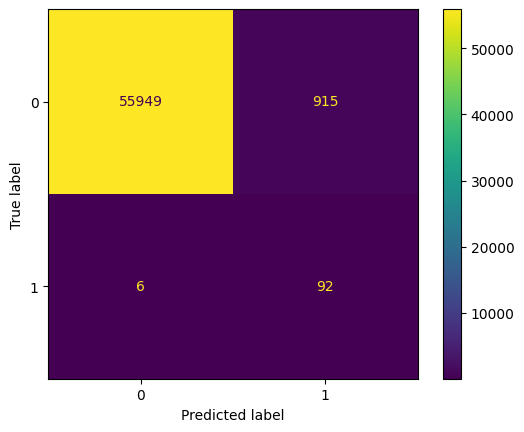

In [ ]:
print("Results for Random Forest model with undersampling on original test: ")
print(classification_report(y_test, preds_test_rf_us))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_test_rf_us))
plt.plot()

proba_train_rf_us = best_model_rf_us.predict_proba(X_train_us)[:, 1]
proba_test_rf_us = best_model_rf_us.predict_proba(X_test)[:, 1]
print(average_precision_score(y_train_us, proba_train_rf_us))
print(average_precision_score(y_test, proba_test_rf_us))


In [ ]:
best_model_rf_us

In [ ]:
best_model_xgb_us, preds_train_xgb_us, preds_test_xgb_us = (
    best_model_randomized_search_cv(
        n_iter=50,
        estimator=xgb.XGBClassifier(),
        search_space=xgb_search_space,

        cv=skf,
        n_jobs=-1,
        scoring="average_precision",
        X_train=X_train_us,
        y_train=y_train_us,
        X_test=X_test,
    )
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Results for XGBoost model with undersampling on original test: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      1.00      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.98      0.54     56962
weighted avg       1.00      0.97      0.98     56962

1.0
0.7212395644340528
0.9989834320053289


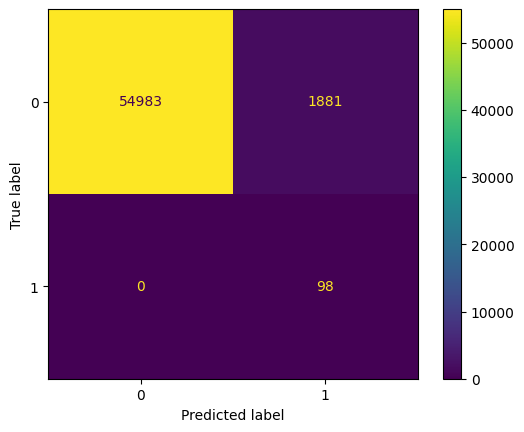

In [ ]:
print("Results for XGBoost model with undersampling on original test: ")
print(classification_report(y_test, preds_test_xgb_us))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_test_xgb_us))
plt.plot()

proba_train_xgb_us = best_model_xgb_us.predict_proba(X_train_us)[:, 1]
proba_test_xgb_us = best_model_xgb_us.predict_proba(X_test)[:, 1]
print(average_precision_score(y_train_us, proba_train_xgb_us))
print(average_precision_score(y_test, proba_test_xgb_us))


SMOTE

One approach to addressing imbalanced datasets is to oversample the minority class by synthesizing new frauds from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, then evaluate the model on the stratified but non-transformed test set.

This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.

Placing SMOTE inside the pipeline during cross-validation significantly increases computational cost but XGBoost has built-in GPU acceleration. 

While applying SMOTE within each cross-validation fold of RandomizedSearch, the model never sees the entire balanced dataset during parameter selection.


GPU-acceleration for RandomForest is possible with RAPIDS but due to software constraints on Windows, I decided to use the sequential approach for Random Forest model. This approach has some data leakage concerns since the same synthetic samples appear across different CV folds. It is methodologically imperfect but much faster. 
I applied SMOTE prior to RandomizedSearchCV for the Random Forest model, while using an integrated SMOTE approach with GPU acceleration for XGBoost. To validate this methodological difference, I conducted hold-out testing between the two approaches.
I found negligible performance differences (less than 1% in average precision and ROC AUC), confirming that this approach maintains model integrity while enabling efficient hyperparameter tuning.


In [ ]:
# I will be using X, y from original data and only applying SMOTE on training data
xgb_search_space_smote = {
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.1),
    "model__n_estimators": randint(100, 1000),
    "model__subsample": uniform(0.5, 0.5),
    "model__colsample_bytree": uniform(0.5, 0.5),
}

skf = StratifiedKFold(n_splits=5)
pipeline_xgb = Pipeline(
    [
        ("over", SMOTE()),
        ("model", xgb.XGBClassifier(tree_method="gpu_hist", gpu_id=0, n_jobs=1)),
    ]
)

In [ ]:
best_model_xgb_sm, preds_train_xgb_sm, preds_test_xgb_sm = (
    best_model_randomized_search_cv(
        n_iter=20,
        estimator=pipeline_xgb,
        search_space=xgb_search_space_smote,

        cv=skf,
        n_jobs=-1,
        scoring="average_precision",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
    )

)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Results for XGBoost model with SMOTE on original test: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.84      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

1.0
0.8738379379449034
0.9731618871521597


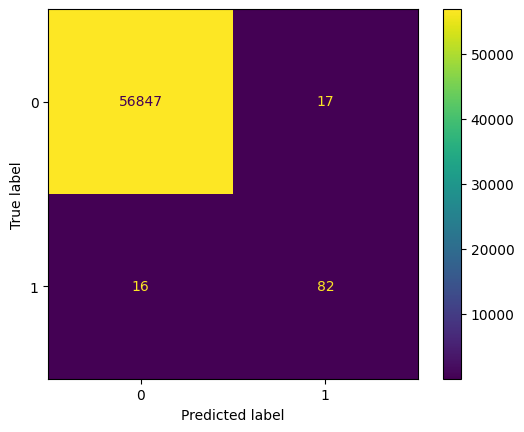

In [ ]:
print("Results for XGBoost model with SMOTE on original test: ")
print(classification_report(y_test, preds_test_xgb_sm))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_test_xgb_sm))
plt.plot()

proba_train_xgb_sm = best_model_xgb_sm.predict_proba(X_train)[:, 1]
proba_test_xgb_sm = best_model_xgb_sm.predict_proba(X_test)[:, 1]
print(average_precision_score(y_train, proba_train_xgb_sm))
print(average_precision_score(y_test, proba_test_xgb_sm))


In [19]:
skf = StratifiedKFold(n_splits=4)
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)


rf_search_space = {
    "n_estimators": range(10, 101),
    "criterion": ["gini", "entropy"],
    "max_depth": range(2, 51),
    "min_samples_split": range(2, 11),
    "min_samples_leaf": range(1, 11),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
}


rf_model = RandomForestClassifier()

random_search_smote_rf = RandomizedSearchCV(
    n_iter=20,
    estimator=rf_model,
    param_distributions=rf_search_space,
    cv=skf,
    verbose=2,
    n_jobs=-1,
    scoring="average_precision",
)

random_search_smote_rf.fit(X_train_smote, y_train_smote)

best_model_smote_rf = random_search_smote_rf.best_estimator_

preds_train_smote_rf = best_model_smote_rf.predict(X_train_smote)
preds_test_smote_rf = best_model_smote_rf.predict(X_test)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


Results for Random Forest model with SMOTE on original test: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

1.0
0.8786781285549911
0.9745842748326118


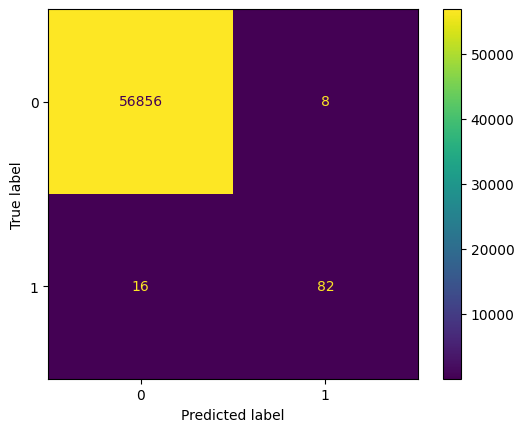

In [ ]:
print("Results for Random Forest model with SMOTE on original test: ")
print(classification_report(y_test, preds_test_smote_rf))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_test_smote_rf))
plt.plot()

proba_train_smote_rf = best_model_smote_rf.predict_proba(X_train_smote)[:, 1]
proba_test_smote_rf = best_model_smote_rf.predict_proba(X_test)[:, 1]


print(average_precision_score(y_train_smote, proba_train_smote_rf))
print(average_precision_score(y_test, proba_test_smote_rf))


In [ ]:
# Hold-out Test Set Validation

# Train an integrated pipeline with the same hyperparameters
pipeline_model = Pipeline(
    [
        ("smote", SMOTE()),
        ("classifier", RandomForestClassifier(**random_search_smote_rf.best_params_)),
    ]
)
pipeline_model.fit(X_train, y_train)

# Already got predictions on hold-out test set - proba_test_smote_rf

# Integrated approach
preds_test_int = pipeline_model.predict(X_test)
proba_test_int = pipeline_model.predict_proba(X_test)[:, 1]

# Compare performance metrics
print("Sequential Approach:")
print(f"Average Precision: {average_precision_score(y_test, proba_test_smote_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, proba_test_smote_rf):.4f}")

print("\nIntegrated Approach:")
print(f"Average Precision: {average_precision_score(y_test, proba_test_int):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, proba_test_int):.4f}")

Sequential Approach:
Average Precision: 0.8787
ROC AUC: 0.9746

Integrated Approach:
Average Precision: 0.8793
ROC AUC: 0.9804


Cost-Sensitive Learning

I will use cost sensitive decision tree classifier - it provides the class_weight argument that will be set to 'balanced'.

In [56]:
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

dt_search_space = {
    "max_depth": [None, 3, 5, 10, 20, 30],
    "min_samples_split": range(2, 10),
    "min_samples_leaf": range(1, 10),
    "max_features": range(1, 10),
    "criterion": ["gini", "entropy"],
}



In [63]:
best_model_dt, preds_train_dt, preds_test_dt = best_model_randomized_search_cv(
    n_iter=50,
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    search_space=dt_search_space,
    cv=skf,
    n_jobs=-1,
    scoring="average_precision",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Results for Random Forest model with SMOTE on original test: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.48      0.85      0.61        98

    accuracy                           1.00     56962
   macro avg       0.74      0.92      0.81     56962
weighted avg       1.00      1.00      1.00     56962

0.9441160854373412
0.8131582168926311
0.9233072572726335


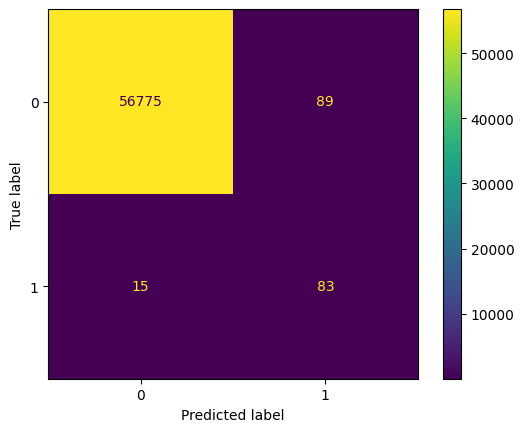

In [ ]:
print("Results for Random Forest model with SMOTE on original test: ")
print(classification_report(y_test, preds_test_dt))
plt = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_test_dt))
plt.plot()

proba_train_dt = best_model_dt.predict_proba(X_train)[:, 1]
proba_test_dt = best_model_dt.predict_proba(X_test)[:, 1]


print(average_precision_score(y_train, proba_train_dt))
print(average_precision_score(y_test, proba_test_dt))




Text(0.5, 1.0, 'Precision-Recall curve comparison')

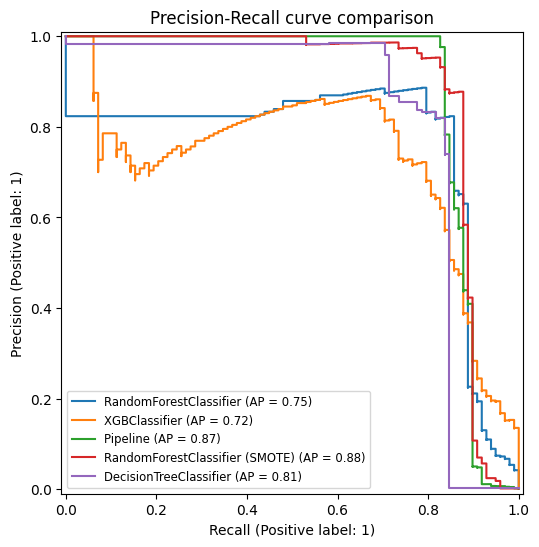

In [124]:
_, ax = plt.subplots(figsize=(6, 6))
fig = PrecisionRecallDisplay.from_estimator(best_model_rf_us, X_test, y_test, ax=ax)
fig = PrecisionRecallDisplay.from_estimator(best_model_xgb_us, X_test, y_test, ax=ax)
fig = PrecisionRecallDisplay.from_estimator(best_model_xgb_sm, X_test, y_test, ax=ax)
fig = PrecisionRecallDisplay.from_estimator(best_model_smote_rf, X_test, y_test, ax=ax, name = 'RandomForestClassifier (SMOTE)')
fig = PrecisionRecallDisplay.from_estimator(best_model_dt, X_test, y_test, ax=ax)
plt.legend(fontsize = 'small')
plt.title("Precision-Recall curve comparison")
